TODO:
-Dropout beim training hinzufügen
-early stopping hinzufügen
-hyperparameter suche hinzufügen
-kommentare hinzufügen die sagen warum ich diese Schritte gehen und nicht andere nehme


# Deep Learning project: Face Recognition

The following notebook is about training a face recognition model with deep learning methods. For this purpose, an own dataset with face images is to be created. With these images different models should be trained and finally compared. The project is part of the [Deep Learning](https://ilias.hs-heilbronn.de/ilias.php?ref_id=20660&cmdClass=ilrepositorygui&cmdNode=xo&baseClass=ilrepositorygui) course at the University of Heilbronn and serves educational purposes.

---

**Author:**

Dominik Bücher, Hochschuhle Heilbronn, Automotive System Engineering Master

dbuecher@stud.hs-heilbronn.de


**Professor:**

Prof. Dr.-Ing. Nicolaj Stache 

nicolaj.stache@hs-heilbronn.de 

---



## Table of Contents

#### 1. [Introduction](#Introduction)
#### 2. [Import of Librarys](#Import)
#### 3. [Presenting the dataset](#dataset)
#### 4. [Import the dataset](#dataset2)
#### 5. [Data augmentation](#augmentation)
#### 6. [Models](#models)
#### 7. [Training](#training)
#### 8. [Evaluation](#eva)
#### 9. [Testing](#testing)
#### 10. [Live face recognition](#live)
#### 11. [Discussion of the results](#Conclusion)


## 1. Introduction <a id="Introduction"></a>

Hier wird kurz erklärt was alles gemacht wird


![image.png](data/test/Dominik/image_0.jpg)

## 2. Import of Librarys <a id="Import"></a>

In [2]:
%pip install fast_ml
%pip install -U efficientnet
%pip install cv2

  Using cached fast_ml-3.68-py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached efficientnet-1.1.1-py3-none-any.whl (18 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached tifffile-2023.4.12-py3-none-any.whl (219 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-win_amd64.whl (4.2 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [1]:
# import the necessary packages
import os
import zipfile
# import matplotlib as plt
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf

# from pyimagesearch.resnet import ResNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img
from matplotlib import pyplot
import efficientnet.keras as efn

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, ResNet101, InceptionV3
import numpy as np
from PIL import Image
from PIL import Image, ImageOps
from keras.models import load_model


## 3. Presenting the dataset <a id="dataset"></a>

Datensatz vorstellen

## 4. Import the dataset <a id="dataset2"></a>

**Dataset structure:**
The database is structured as follows. So that the different types of images can be clearly structured, the following structure was created
```
- face_dataset
    |- Dominik 
        |- image_0.jpeg
        |- image_1.jpeg
        |- image_2.jpeg
        |- ...
    |- Unknown
        |- image_0.jpeg
        |- image_1.jpeg
        |- image_2.jpeg
        |- ...
```



```
- data
    |-train
        |- Dominik 
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
        |- Unknown
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
    |-validation
        |- Dominik 
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
        |- Unknown
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
    |-test
        |- Dominik 
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
        |- Unknown
            |- image_0.jpeg
            |- image_1.jpeg
            |- image_2.jpeg
            |- ...
```

In [63]:
################ Unzip the dataset in the Colab runtime ##################

# Specify the path to the ZIP file containing the face dataset
zip_file_path = 'data/face_dataset.zip'

# Combine the path with the ZIP file
pathToZip = os.path.join(zip_file_path)

# Print a message indicating the file being unzipped
print("Unzipping {}".format(pathToZip))

# Specify the path where the extracted data will be stored
pathToData = "/tmp"

# Open the ZIP file and extract its contents to the specified path
with zipfile.ZipFile(pathToZip, 'r') as zip_ref:
    zip_ref.extractall(pathToData)

# Retrieve the paths of the images for 'Dominik' and 'Unknown' categories
data_dominik = glob.glob(os.path.join(pathToData, "face_dataset/Dominik/" + "*.jpeg"))
data_unknown = glob.glob(os.path.join(pathToData, "face_dataset/Unknown/" + "*.jpeg"))

# Print the number of image paths found for 'Dominik' and 'Unknown' categories
print("Dominik: {} image paths".format(len(data_dominik)))
print("Unknown: {} image paths".format(len(data_unknown)))


unzipping data/face_dataset.zip
Dominik : 300 image paths
Unknown : 150 image paths


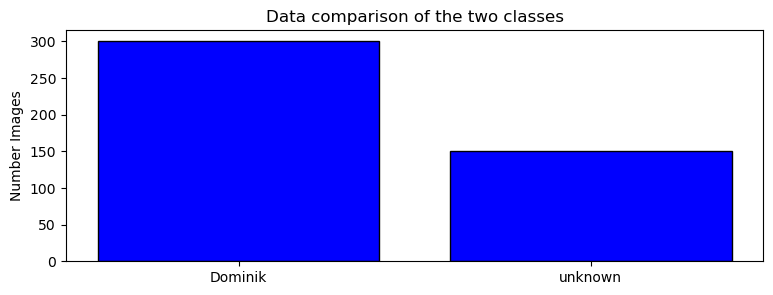

In [64]:
# Create a list of class names
names = ['Dominik', 'Unknown']

# Create a list of values representing the number of images in each class
values = [len(data_dominik), len(data_unknown)]

plt.figure(figsize=(9, 3)) # Set up the figure size for the bar chart
plt.bar(names, values, color='blue', edgecolor='black') # Create a bar chart with the class names as x-axis labels and the values as bar heights
plt.ylabel('Number Images') # Set the label for the y-axis
plt.title('Data comparison of the two classes') # Set the title of the chart
plt.show() # Display the chart


In [65]:
# Create an empty list to store the resized images for the 'Dominik' class
images_dominik = []

# Iterate over each JPEG file in the '/tmp/face_dataset/Dominik/' directory
for filename in glob.glob("/tmp/face_dataset/Dominik/" + "*.jpeg"):
    
    # Open the image file using PIL's Image module
    im = Image.open(filename)   
    # Perform any necessary image orientation adjustment using ImageOps.exif_transpose
    # This is need because the image are sometimes roted while saving
    im = ImageOps.exif_transpose(im)  
    # Resize the image to a target size of 224x224 pixels
    resized_im = im.resize([224, 224]) 
    # Append the resized image to the 'images_dominik' list
    images_dominik.append(resized_im)

# Print the number of resized images for the 'Dominik' class
print("Dominik list:", len(images_dominik))
# Print the first resized image in the 'images_dominik' list
print(images_dominik[0])


# Create an empty list to store the resized images for the 'Unknown' class
images_unknown = []

# Iterate over each JPEG file in the '/tmp/face_dataset/Unknown/' directory
for filename in glob.glob("/tmp/face_dataset/Unknown/" + "*.jpeg"):
   
    # Open the image file using PIL's Image module
    im = Image.open(filename)
    # Perform any necessary image orientation adjustment using ImageOps.exif_transpose
    # This is need because the image are sometimes roted while saving
    im = ImageOps.exif_transpose(im)
    # Resize the image to a target size of 224x224 pixels
    resized_im = im.resize([224, 224])
    # Append the resized image to the 'images_unknown' list
    images_unknown.append(resized_im)


# Print the number of resized images for the 'Unknown' class
print("Unknown list:", len(images_unknown))
# Print the first resized image in the 'images_unknown' list
print(images_unknown[0])



list:  300
<PIL.Image.Image image mode=RGB size=224x224 at 0x2211A425100>
list:  150
<PIL.Image.Image image mode=RGB size=224x224 at 0x22136D5FDC0>


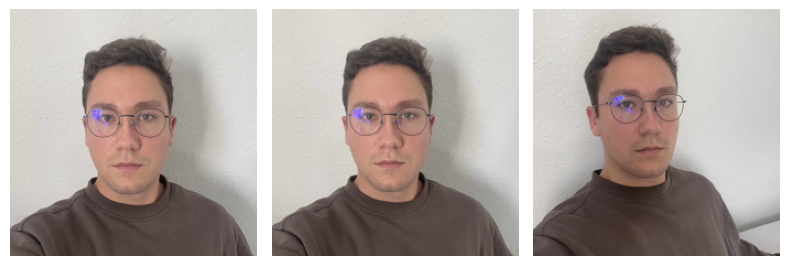

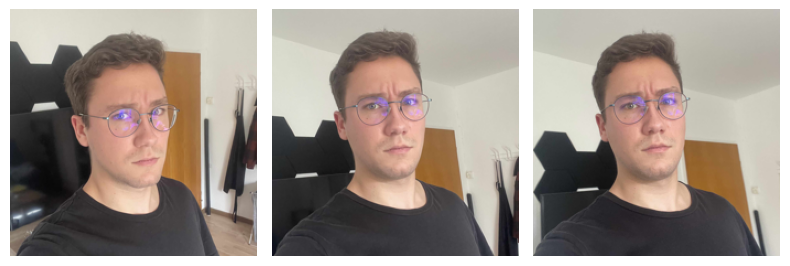

In [66]:
# Display 
for i in range(0,6,3):
    # Create a figure and axes
    fig, ax = plt.subplots(1,3, figsize=(8, 4))

    # Display the image
    ax[0].imshow(images_dominik[i])
    ax[1].imshow(images_dominik[i+1])
    ax[2].imshow(images_dominik[i+2])

    # Add a legend
    legend_text = ""
    ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    # ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    
    # Remove the axis labels
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

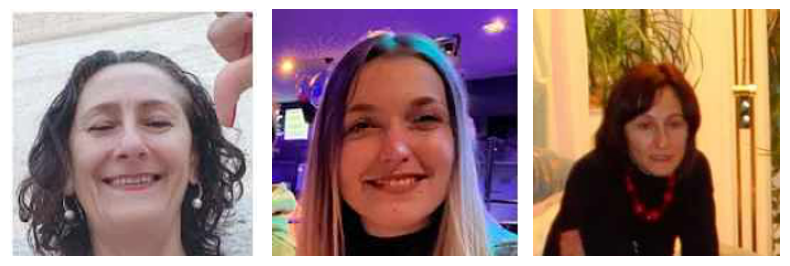

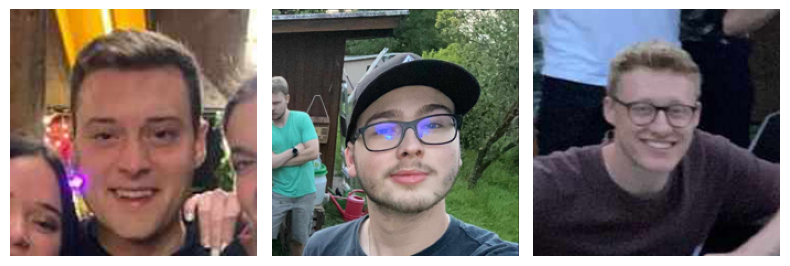

In [68]:
for i in range(0,6,3):
    # Create a figure and axes
    fig, ax = plt.subplots(1,3, figsize=(8, 4))

    # Display the image
    ax[0].imshow(images_unknown[i])
    ax[1].imshow(images_unknown[i+1])
    ax[2].imshow(images_unknown[i+2])

    # Add a legend
    legend_text = ""
    ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    # ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    
    # Remove the axis labels
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [69]:
# Create an empty list to store the normalized images for the 'Dominik' class
images_dominik_norm = []

# Iterate over each resized image in the 'images_dominik' list
for i in range(len(images_dominik)):
    # Convert the resized image to an array
    temp_data = img_to_array(images_dominik[i])
    # Normalize the image array using cv2.normalize, scaling the values between 0 and 1
    img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Convert the normalized array back to an image and append it to the 'images_dominik_norm' list
    images_dominik_norm.append(array_to_img(img_norm))

# Print the number of normalized images for the 'Dominik' class
print("Dominik normalized list:", len(images_dominik_norm))
# Print the first normalized image in the 'images_dominik_norm' list
print(images_dominik_norm[0])


# Create an empty list to store the normalized images for the 'Unknown' class
images_unknown_norm = []

# Iterate over each resized image in the 'images_unknown' list
for i in range(len(images_unknown)):
    # Convert the resized image to an array
    temp_data = img_to_array(images_unknown[i])
    # Normalize the image array using cv2.normalize, scaling the values between 0 and 1
    img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Convert the normalized array back to an image and append it to the 'images_unknown_norm' list
    images_unknown_norm.append(array_to_img(img_norm))

# Print the number of normalized images for the 'Unknown' class
print("Unknown normalized list:", len(images_unknown_norm))
# Print the first normalized image in the 'images_unknown_norm' list
print(images_unknown_norm[0])


In [71]:
# Create empty lists to store the labels for the 'Unknown' and 'Dominik' classes
y_unknown = []
y_dominik = []

# Append 'unknown' labels to the 'y_unknown' list for each normalized image in the 'images_unknown_norm' list
# This is needed for the 'train_test_split' function -> every image needs a lable
for i in range(len(images_unknown_norm)):
    y_unknown.append('unknown')

# Append 'Dominik' labels to the 'y_dominik' list for each normalized image in the 'images_dominik_norm' list
# This is needed for the 'train_test_split' function -> every image needs a lable
for i in range(len(images_dominik_norm)):
    y_dominik.append('Dominik')

# Split the 'Unknown' class data into training and remaining datasets using train_test_split
X_train_unknown, X_rem_unknown, y_train_unknown, y_rem_unknown = train_test_split(images_unknown_norm, y_unknown, train_size=0.7)
# Split the 'Dominik' class data into training and remaining datasets using train_test_split
X_train_dominik, X_rem_dominik, y_train_dominik, y_rem_dominik = train_test_split(images_dominik_norm, y_dominik, train_size=0.7)

# Split the remaining 'Unknown' data into validation and test datasets using train_test_split
X_valid_unknown, X_test_unknown, y_valid_unknown, y_test_unknown = train_test_split(X_rem_unknown, y_rem_unknown, test_size=0.3)
# Split the remaining 'Dominik' data into validation and test datasets using train_test_split
X_valid_dominik, X_test_dominik, y_valid_dominik, y_test_dominik = train_test_split(X_rem_dominik, y_rem_dominik, test_size=0.3)


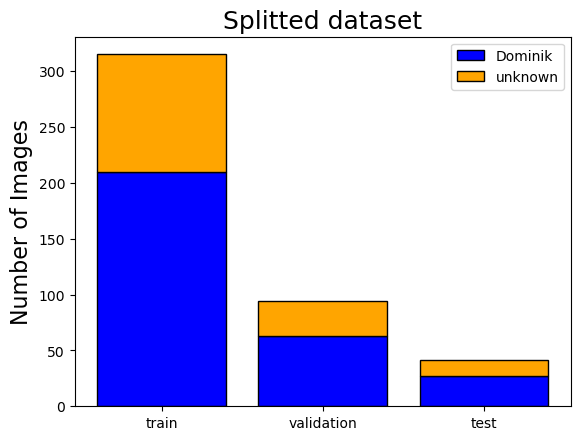

In [72]:
# Define the splits and data origins
split = ['train', 'validation', 'test']
data_origin = ['Dominik', 'unknown']

# Create an array of positions for the bars
pos = np.arange(len(split))

# Create lists of values for the 'Dominik' class for each split
values_dominik = [len(X_train_dominik), len(X_valid_dominik), len(X_test_dominik)]
# Create lists of values for the 'unknown' class for each split
values_unknown = [len(X_train_unknown), len(X_valid_unknown), len(X_test_unknown)]

# Create a bar plot for the 'Dominik' class
plt.bar(pos, values_dominik, color='blue', edgecolor='black')
# Create a bar plot for the 'unknown' class, stacking on top of the 'Dominik' class
plt.bar(pos, values_unknown, color='orange', edgecolor='black', bottom=values_dominik)
# Set the x-axis ticks to the split names
plt.xticks(pos, split)
# Set the y-axis label
plt.ylabel('Number of Images', fontsize=16)
# Set the title of the plot
plt.title('Splitted dataset', fontsize=18)
# Add a legend to differentiate the data origins
plt.legend(data_origin)
# Display the plot
plt.show()

In [73]:
# Save the 'Unknown' class training images
for i in range(len(X_train_unknown)):
    X_train_unknown[i].save(r'data\train\unknown\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Unknown' class validation images
for i in range(len(X_valid_unknown)):
    X_valid_unknown[i].save(r'data\validation\unknown\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Unknown' class test images
for i in range(len(X_test_unknown)):
    X_test_unknown[i].save(r'data\test\unknown\image_' + str(i) + '.jpg', 'JPEG')

In [74]:
# Save the 'Dominik' class training images
for i in range(len(X_train_dominik)):
    X_train_dominik[i].save(r'data\train\Dominik\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Dominik' class validation images
for i in range(len(X_valid_dominik)):
    X_valid_dominik[i].save(r'data\validation\Dominik\image_' + str(i) + '.jpg', 'JPEG')

# Save the 'Dominik' class test images
for i in range(len(X_test_dominik)):
    X_test_dominik[i].save(r'data\test\Dominik\image_' + str(i) + '.jpg', 'JPEG')

## 5. Data augmentation <a id="augmentation"></a>

In [75]:
# Convert images to arrays and expand dimensions for the 'Unknown' class training and validation sets
train_unknown_array = []
for i in range(len(X_train_unknown)):
    train_unknown_array.append(np.expand_dims(img_to_array(X_train_unknown[i]), axis=0))

valid_unknown_array = []
for i in range(len(X_valid_unknown)):
    valid_unknown_array.append(np.expand_dims(img_to_array(X_valid_unknown[i]), axis=0))


# Convert images to arrays and expand dimensions for the 'Dominik' class training and validation sets
train_dominik_array = []
for i in range(len(X_train_dominik)):
    train_dominik_array.append(np.expand_dims(img_to_array(X_train_dominik[i]), axis=0))

valid_dominik_array = []
for i in range(len(X_valid_dominik)):
    valid_dominik_array.append(np.expand_dims(img_to_array(X_valid_dominik[i]), axis=0))


In [76]:
# Data augmentation parameters
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
zoom_range = 0.2
brightness_range = [0.4, 1.2]
fill_mode = 'reflect'

# Data augmentation for the 'Unknown' class training and validation sets
train_unknown_datagen = ImageDataGenerator(width_shift_range=width_shift_range, height_shift_range=height_shift_range, horizontal_flip=True, rotation_range=rotation_range, brightness_range=brightness_range, zoom_range=zoom_range, fill_mode=fill_mode)
validation_unknown_datagen = ImageDataGenerator(width_shift_range=width_shift_range, height_shift_range=height_shift_range, horizontal_flip=True, rotation_range=rotation_range, brightness_range=brightness_range, zoom_range=zoom_range, fill_mode=fill_mode)

# Data augmentation for the 'Dominik' class training and validation sets
train_dominik_datagen = ImageDataGenerator(width_shift_range=width_shift_range, height_shift_range=height_shift_range, horizontal_flip=True, rotation_range=rotation_range, brightness_range=brightness_range, zoom_range=zoom_range, fill_mode=fill_mode)
validation_dominik_datagen = ImageDataGenerator(width_shift_range=width_shift_range, height_shift_range=height_shift_range, horizontal_flip=True, rotation_range=rotation_range, brightness_range=brightness_range, zoom_range=zoom_range, fill_mode=fill_mode)


# Generate augmented images for the 'Unknown' class training set
for i in range(len(train_unknown_array)):
    train_generator_unknown = train_unknown_datagen.flow(train_unknown_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = train_generator_unknown.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    # save the augmented images in the same folder as the original images of the unknown class
    im.save(r'data\train\unknown\augmented_image_' + str(i) + '.jpg')

# Generate augmented images for the 'Unknown' class validation set
for i in range(len(valid_unknown_array)):
    valid_generator_unknown = validation_unknown_datagen.flow(valid_unknown_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = valid_generator_unknown.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    # save the augmented images in the same folder as the original images of the unknown class
    im.save(r'data\validation\unknown\augmented_image_' + str(i) + '.jpg')

# Generate augmented images for the 'Dominik' class training set
for i in range(len(train_dominik_array)):
    train_generator_dominik = train_dominik_datagen.flow(train_dominik_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = train_generator_dominik.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    # save the augmented images in the same folder as the original images of the Dominik class
    im.save(r'data\train\Dominik\augmented_image_' + str(i) + '.jpg')

# Generate augmented images for the 'Dominik' class validation set
for i in range(len(valid_dominik_array)):
    valid_generator_dominik = validation_dominik_datagen.flow(valid_dominik_array[i], batch_size=1)
    # Generate a batch of augmented images
    batch = valid_generator_dominik.next()
    img_norm = cv2.normalize(batch[0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = array_to_img(img_norm)
    # save the augmented images in the same folder as the original images of the Dominik class
    im.save(r'data\validation\Dominik\augmented_image_' + str(i) + '.jpg')


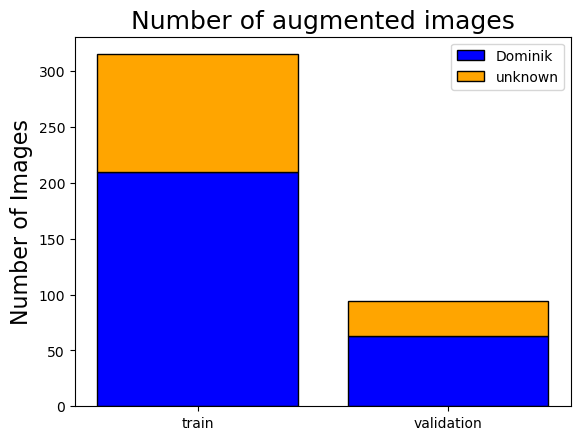

In [77]:
# Define the splits and data origins for the plot
split = ['train', 'validation']
data_origin = ['Dominik', 'unknown']

# Create an array of positions based on the number of splits
pos = np.arange(len(split))

# Prepare the values for the 'train' split
values_train = [len(train_dominik_array), len(valid_dominik_array)]

# Prepare the values for the 'validation' split
values_valid = [len(train_unknown_array), len(valid_unknown_array)]

# Plotting the bar chart
plt.bar(pos, values_train, color='blue', edgecolor='black')
plt.bar(pos, values_valid, color='orange', edgecolor='black', bottom=values_train)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Number of augmented images', fontsize=18)
plt.legend(data_origin)
plt.show()


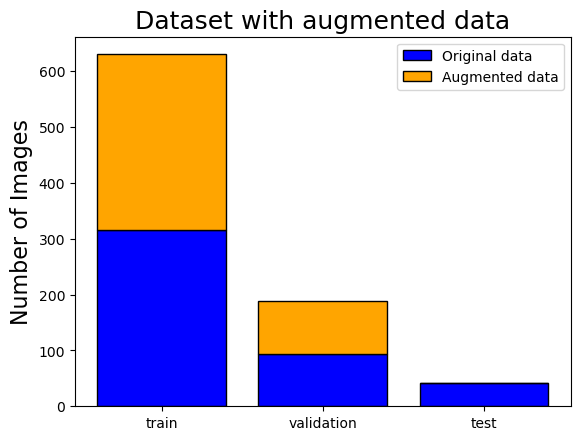

In [78]:
# Define the splits and data origins for the plot
split = ['train', 'validation', 'test']
data_origin = ['Original data', 'Augmented data']

# Create an array of positions based on the number of splits
pos = np.arange(len(split))

# Prepare the values for the 'Original data' bars
values_og = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), len(X_test_unknown+X_test_dominik)]

# Prepare the values for the 'Augmented data' bars
values_augmented = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), 0]

# Plotting the bar chart
plt.bar(pos, values_og, color='blue', edgecolor='black')
plt.bar(pos, values_augmented, color='orange', edgecolor='black', bottom=values_og)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Dataset with augmented data', fontsize=18)
plt.legend(data_origin)
plt.show()


## 6. Models <a id="models"></a>

Models vorstellen

In [79]:
# Define the input shape for the model
input_shape = (224, 224, 3)

# Specify the weights to be used with 'imagenet'
weights = 'imagenet'

In [92]:
# Create a base model using ResNet50 architecture
ResNet50_base_model = ResNet50(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in ResNet50_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
ResNet50_model = tf.keras.Sequential([
    ResNet50_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [93]:
# Create the ResNet101 model
ResNet101_base_model = ResNet101(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in ResNet101_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
ResNet101_model = tf.keras.Sequential([
    ResNet101_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [94]:
# Create the EfficientNetB0 model
EfficientNetB0_base_model = efn.EfficientNetB0(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in EfficientNetB0_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
EfficientNetB0_model = tf.keras.Sequential([
    EfficientNetB0_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [95]:
# Create the VGG16 model
VGG16_base_model = VGG16(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in VGG16_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
VGG16_model = tf.keras.Sequential([
    VGG16_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [96]:
# Create the InceptionV3 model
InceptionV3_base_model = InceptionV3(include_top=False, input_shape=input_shape, weights=weights)

# Freeze the layers of the base model
for layer in InceptionV3_base_model.layers:
    layer.trainable = False

# Add a classification head on top of the base model
InceptionV3_model = tf.keras.Sequential([
    InceptionV3_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

## 7. Training <a id="training"></a>

In [85]:
# if you want more augmented data you can uncomment the parameters in the ImageDataGenerator
# so there are created more augmented images while trainind
train_datagen = ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

validation_datagen = ImageDataGenerator()

In [86]:
# Create data generators for training and validation data

# Define the desired size for input images
IMAGE_SIZE = (224, 224)

# Set the batch size for each iteration during training
batch_size = 16

# Specify the directories containing the training and validation data
train_dir = "data/train/"
val_dir = "data/validation/"

# Create a data generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,                            # Directory containing the training data
    batch_size=batch_size,                # Number of samples per batch
    target_size=IMAGE_SIZE,               # Resize input images to the specified size
    shuffle=True,                         # Shuffle the order of images during training
    class_mode='categorical'              # Generate one-hot encoded labels for multi-class classification
)

# Create a data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
    val_dir,                              # Directory containing the validation data
    batch_size=batch_size,                # Number of samples per batch
    target_size=IMAGE_SIZE,               # Resize input images to the specified size
    shuffle=True,                         # Shuffle the order of images during validation
    class_mode='categorical'              # Generate one-hot encoded labels for multi-class classification
)

Found 630 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [98]:
# Compile the models

# Set the optimizer, loss function, and metrics for evaluation
optimizer = 'rmsprop'    # Options: 'adam', 'rmsprop'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Compile each model with the specified optimizer, loss, and metrics
VGG16_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
ResNet50_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
ResNet101_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
EfficientNetB0_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
InceptionV3_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [99]:
# Train the models

# Calculate the total number of validation images
total_val = 2 * len(valid_dominik_array + valid_unknown_array)

# Set the number of epochs for training
epochs = 5

# Calculate the steps per epoch and validation steps
steps_per_epoch = total_val // batch_size
validation_steps = total_val // batch_size

# Train each model and store the training history

# VGG16 model
print('VGG16:')
history_VGG16 = VGG16_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps)

# ResNet50 model
print('ResNet50:')
history_ResNet50 = ResNet50_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps)

# ResNet101 model
print('ResNet101:')
history_ResNet101 = ResNet101_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps)

# EfficientNetB0 model
print('EfficientNetB0:')
history_EfficientNetB0 = EfficientNetB0_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps)

# InceptionV3 model
print('InceptionV3:')
history_InceptionV3 = InceptionV3_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps)

VGG16:
Epoch 1/5
11/11 [==============================] - 12s 1s/step - loss: 2.1906 - accuracy: 0.5511 - val_loss: 1.4594 - val_accuracy: 0.7330
Epoch 2/5
11/11 [==============================] - 11s 1s/step - loss: 0.9816 - accuracy: 0.7349 - val_loss: 0.8249 - val_accuracy: 0.7955
Epoch 3/5
11/11 [==============================] - 12s 1s/step - loss: 0.5462 - accuracy: 0.8466 - val_loss: 0.5991 - val_accuracy: 0.8580
Epoch 4/5
11/11 [==============================] - 11s 1s/step - loss: 0.2802 - accuracy: 0.9036 - val_loss: 0.4154 - val_accuracy: 0.8807
Epoch 5/5
11/11 [==============================] - 12s 1s/step - loss: 0.3723 - accuracy: 0.9091 - val_loss: 0.3626 - val_accuracy: 0.9034
ResNet50:
Epoch 1/5
11/11 [==============================] - 7s 671ms/step - loss: 0.3182 - accuracy: 0.8855 - val_loss: 0.1387 - val_accuracy: 0.9716
Epoch 2/5
11/11 [==============================] - 7s 617ms/step - loss: 0.1267 - accuracy: 0.9659 - val_loss: 0.1288 - val_accuracy: 0.9773
Epoch 

In [100]:
# Save the weights of the trained models
VGG16_model.save_weights('models/VGG16_model_weights.h5')
ResNet50_model.save_weights('models/ResNet50_model_weights.h5')
ResNet101_model.save_weights('models/ResNet101_model_weights.h5')
EfficientNetB0_model.save_weights('models/EfficientNetB0_model_weights.h5')
InceptionV3_model.save_weights('models/InceptionV3_model_weights.h5')

# Save the entire trained models
VGG16_model.save('models/VGG16_model.h5')
ResNet50_model.save('models/ResNet50_model.h5')
ResNet101_model.save('models/ResNet101_model.h5')
EfficientNetB0_model.save('models/EfficientNetB0_model.h5')
InceptionV3_model.save('models/InceptionV3_model.h5')

## 8. Evaluation <a id="eva"></a>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


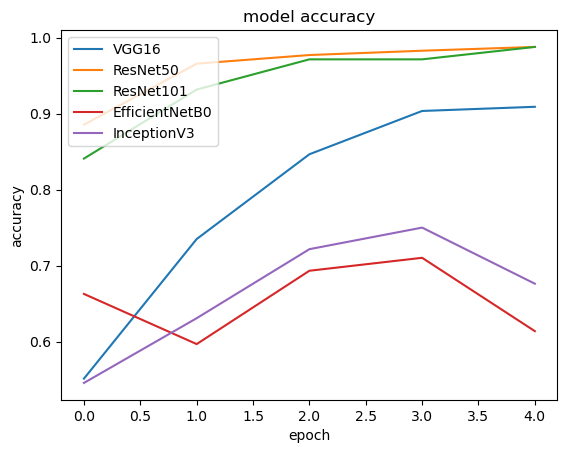

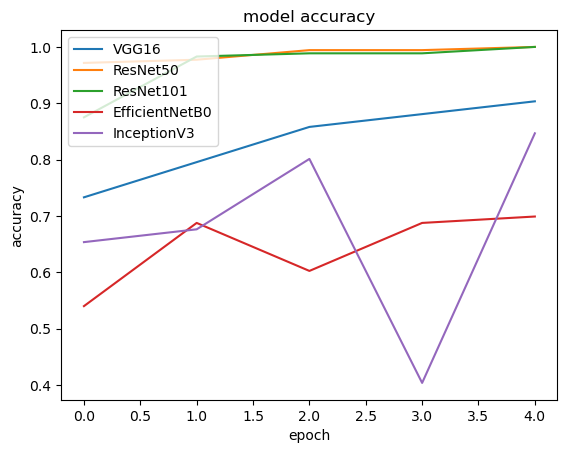

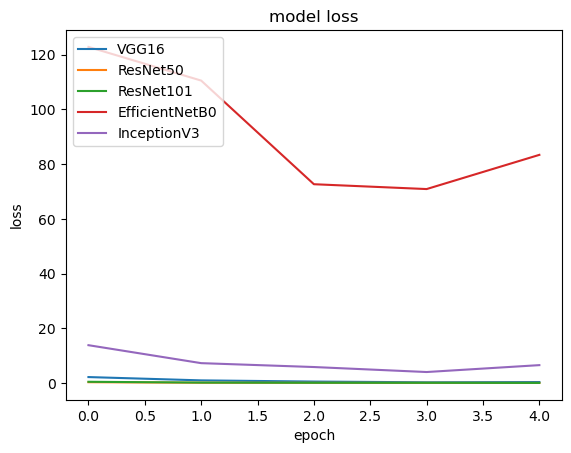

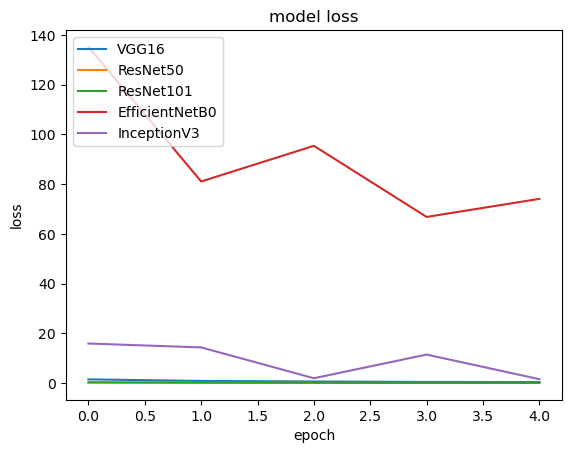

In [101]:
# Plot training & validation accuracy values of VGG16
print(history_VGG16.history.keys())
#  "Accuracy"
plt.plot(history_VGG16.history['accuracy'], label = "VGG16")
plt.plot(history_ResNet50.history['accuracy'], label = "ResNet50")
plt.plot(history_ResNet101.history['accuracy'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['accuracy'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['accuracy'], label = "InceptionV3")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()

#  "val_accuracy"
plt.plot(history_VGG16.history['val_accuracy'], label = "VGG16")
plt.plot(history_ResNet50.history['val_accuracy'], label = "ResNet50")
plt.plot(history_ResNet101.history['val_accuracy'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['val_accuracy'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['val_accuracy'], label = "InceptionV3")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()


# "Loss"
plt.plot(history_VGG16.history['loss'], label = "VGG16")
plt.plot(history_ResNet50.history['loss'], label = "ResNet50")
plt.plot(history_ResNet101.history['loss'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['loss'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['loss'], label = "InceptionV3")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()

# "val_loss"
plt.plot(history_VGG16.history['val_loss'], label = "VGG16")
plt.plot(history_ResNet50.history['val_loss'], label = "ResNet50")
plt.plot(history_ResNet101.history['val_loss'], label = "ResNet101")
plt.plot(history_EfficientNetB0.history['val_loss'], label = "EfficientNetB0")
plt.plot(history_InceptionV3.history['val_loss'], label = "InceptionV3")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['VGG16', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'InceptionV3'], loc='upper left')
plt.show()

## 9. Testing <a id="testing"></a>

In [6]:
images_dominik_norm = []
for i in range(len(images_dominik)):
        temp_data = img_to_array(images_dominik[i])
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images_dominik_norm.append(array_to_img(img_norm))

In [10]:
import numpy as np
from PIL import Image
from keras.models import load_model


# Load the .h5 models
model_path_VGG16 = 'models/VGG16_model.h5'
model_path_ResNet50 = 'models/ResNet50_model.h5'
model_path_ResNet101 = 'models/ResNet101_model.h5'
model_path_EfficientNetB0 = 'models/EfficientNetB0_model.h5'
model_path_InceptionV3 = 'models/InceptionV3_model.h5'

VGG16_model = load_model(model_path_VGG16)
ResNet50_model = load_model(model_path_ResNet50)
ResNet101_model = load_model(model_path_ResNet101)
EfficientNetB0_model = load_model(model_path_EfficientNetB0)
InceptionV3_model = load_model(model_path_InceptionV3)

# Load and prepare the test images
test_path_dominik = 'data/test/Dominik'
test_path_unknown = 'data/test/unknown'

def getImages(test_image_folder):
    test_images = []
    for image_path in os.listdir(test_image_folder):
        image = Image.open(os.path.join(test_image_folder, image_path))
        temp_data = img_to_array(image)
        img_norm = cv2.normalize(temp_data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        image_norm = array_to_img(img_norm)

        image = image_norm.resize((224, 224))  # Adjust the image size according to your requirements
        image = np.array(image)# / 255.0  # Normalize the image pixels to the range 0-1
        test_images.append(image)

    # Convert the list of images to a Numpy array
    test_images = np.array(test_images)
    return test_images

test_images_dominik = getImages(test_path_dominik)
test_images_unknown = getImages(test_path_unknown)

# Apply the models to the test dataset
predictions_dominik_VGG16_model = VGG16_model.predict(test_images_dominik)
predictions_unknown_VGG16_model = VGG16_model.predict(test_images_unknown)

predictions_dominik_ResNet50_model = ResNet50_model.predict(test_images_dominik)
predictions_unknown_ResNet50_model = ResNet50_model.predict(test_images_unknown)

predictions_dominik_ResNet101_model = ResNet101_model.predict(test_images_dominik)
predictions_unknown_ResNet101_model = ResNet101_model.predict(test_images_unknown)

predictions_dominik_EfficientNetB0_model = EfficientNetB0_model.predict(test_images_dominik)
predictions_unknown_EfficientNetB0_model = EfficientNetB0_model.predict(test_images_unknown)

predictions_dominik_InceptionV3_model = InceptionV3_model.predict(test_images_dominik)
predictions_unknown_InceptionV3_model = InceptionV3_model.predict(test_images_unknown)


In [8]:
def getLabel_from_prediction(predicitons):
    labels = []
    for i in range(len(predicitons)):
        if predicitons[i][0] > 0.75:
            labels.append("Dominik")
        else:
            labels.append("Unknown")
    return labels


labels_dominik_VGG16_model = getLabel_from_prediction(predictions_dominik_VGG16_model)
labels_unknown_VGG16_model = getLabel_from_prediction(predictions_unknown_VGG16_model)

labels_dominik_ResNet50_model = getLabel_from_prediction(predictions_dominik_ResNet50_model)
labels_unknown_ResNet50_model = getLabel_from_prediction(predictions_unknown_ResNet50_model)

labels_dominik_ResNet101_model = getLabel_from_prediction(predictions_dominik_ResNet101_model)
labels_unknown_ResNet101_model = getLabel_from_prediction(predictions_unknown_ResNet101_model)

labels_dominik_EfficientNetB0_model = getLabel_from_prediction(predictions_dominik_EfficientNetB0_model)
labels_unknown_EfficientNetB0_model = getLabel_from_prediction(predictions_unknown_EfficientNetB0_model)

labels_dominik_InceptionV3_model = getLabel_from_prediction(predictions_dominik_InceptionV3_model)
labels_unknown_InceptionV3_model = getLabel_from_prediction(predictions_unknown_InceptionV3_model)

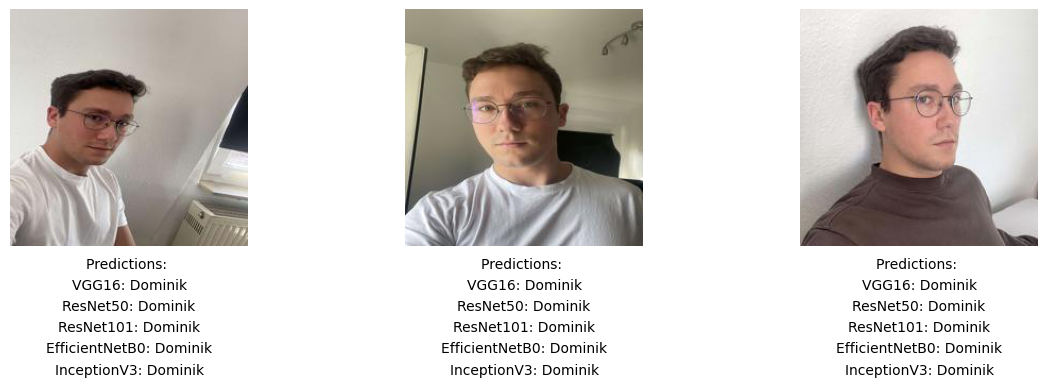

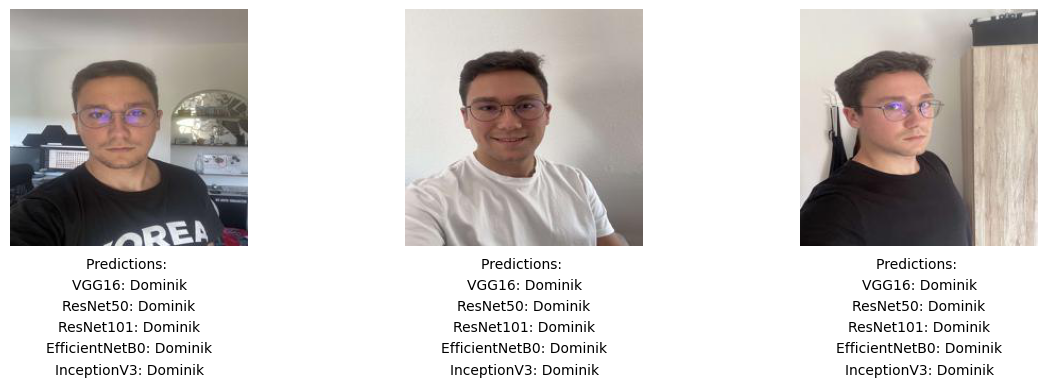

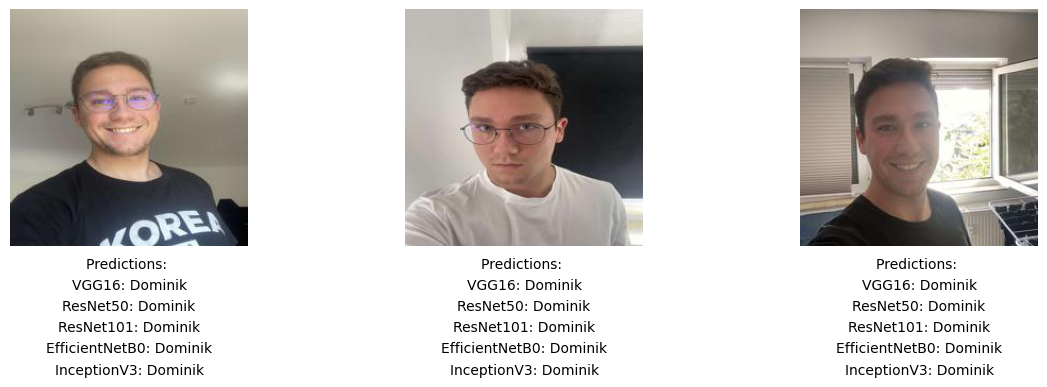

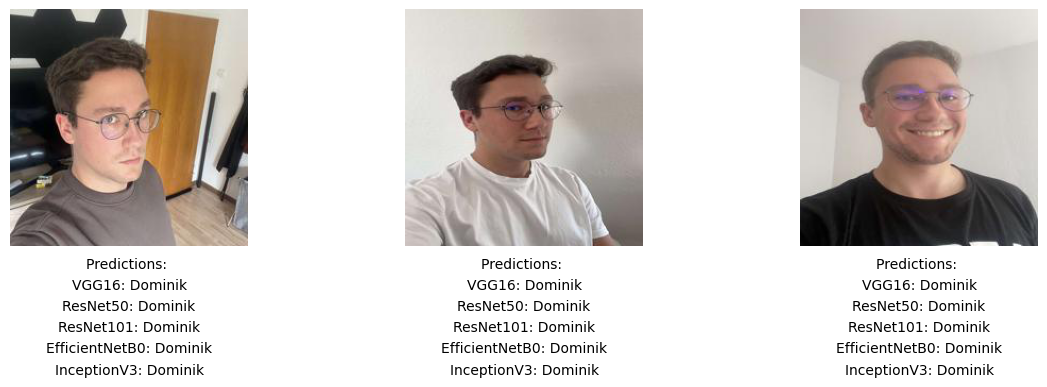

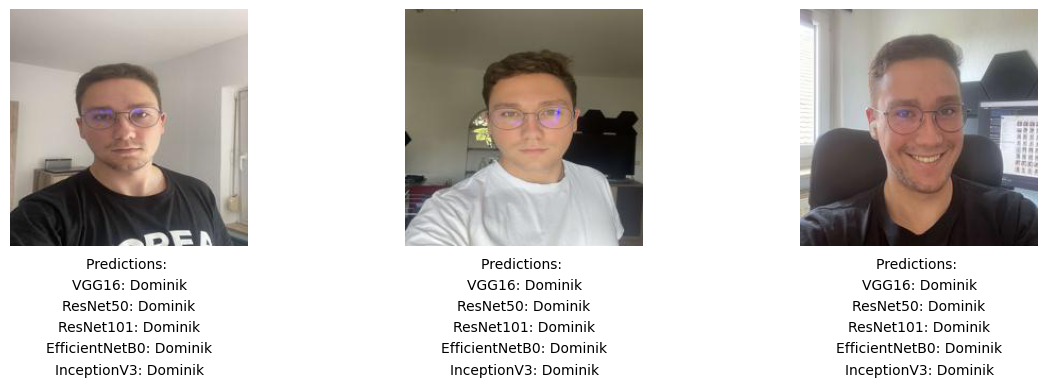

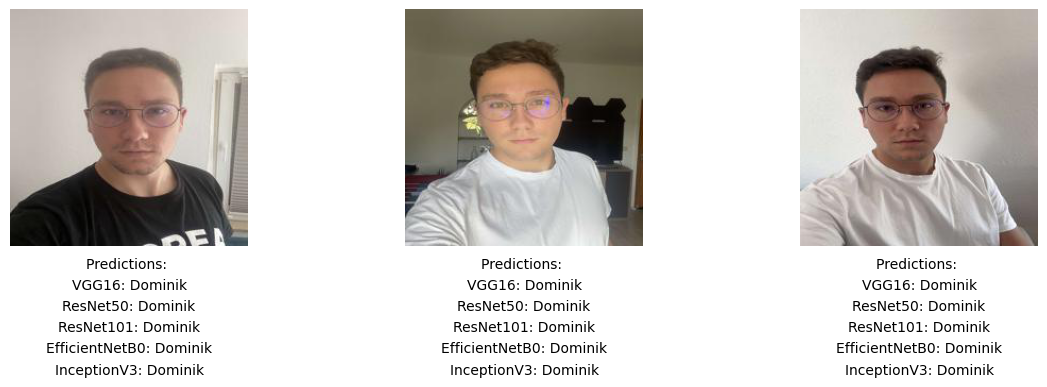

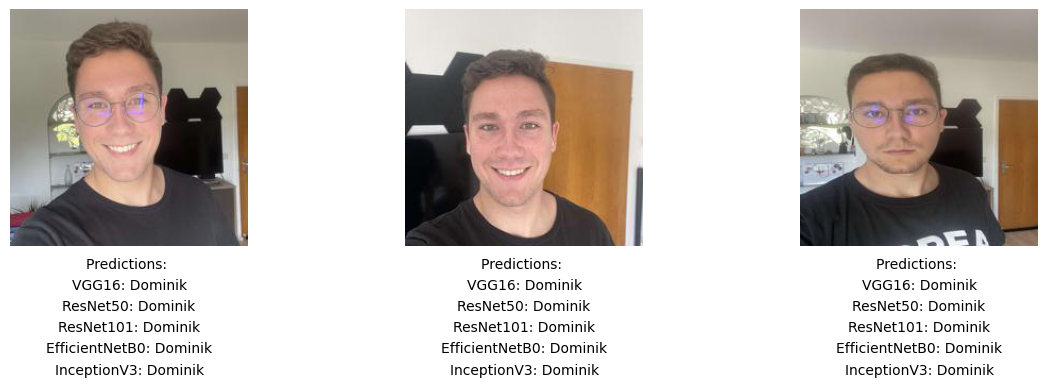

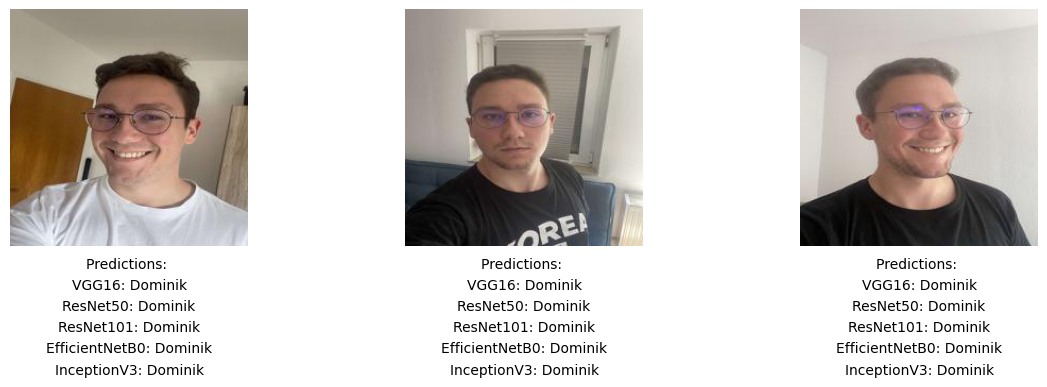

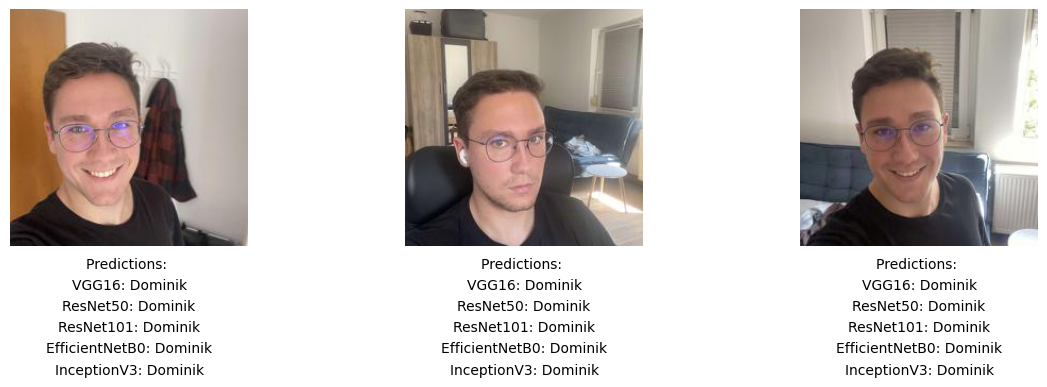

In [50]:
images_dominik = []
for i in range(len(test_images_dominik)):
    image = array_to_img(test_images_dominik[i])
    images_dominik.append(image)


for i in range(0, 27,3):
    # Create a figure and axes
    fig, ax = plt.subplots(1,3, figsize=(12, 4))

    # Display the image
    ax[0].imshow(images_dominik[i])
    ax[1].imshow(images_dominik[i+1])
    ax[2].imshow(images_dominik[i+2])

    # Add a legend
    legend_text = ""
    ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    # ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')
    
    # predictions
    text_vgg16 = "VGG16: " + labels_dominik_VGG16_model[i]
    text_ResNet50 = "ResNet50: " + labels_dominik_ResNet50_model[i]
    text_ResNet101 = "ResNet101: " + labels_dominik_ResNet101_model[i]
    text_EfficientNetB0 = "EfficientNetB0: " + labels_dominik_EfficientNetB0_model[i]
    text_InceptionV3 = "InceptionV3: " + labels_dominik_InceptionV3_model[i]

    # Add text under the image
    text_lines = ["Predictions: ", text_vgg16, text_ResNet50, text_ResNet101, text_EfficientNetB0, text_InceptionV3]
    text_position = (image.width // 2, image.height + 20)
    for line in text_lines:
        ax[0].text(*text_position, line, color='black', ha='center')
        ax[1].text(*text_position, line, color='black', ha='center')
        ax[2].text(*text_position, line, color='black', ha='center')
        text_position = (text_position[0], text_position[1] + 20)
        
    
    # Remove the axis labels
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

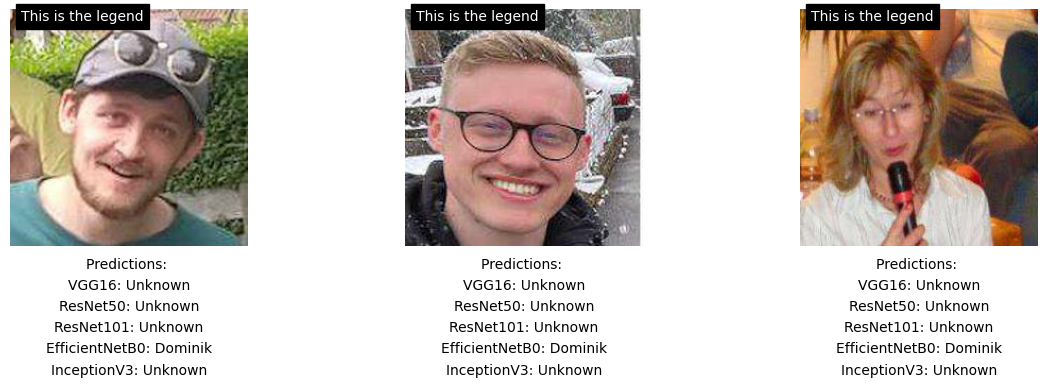

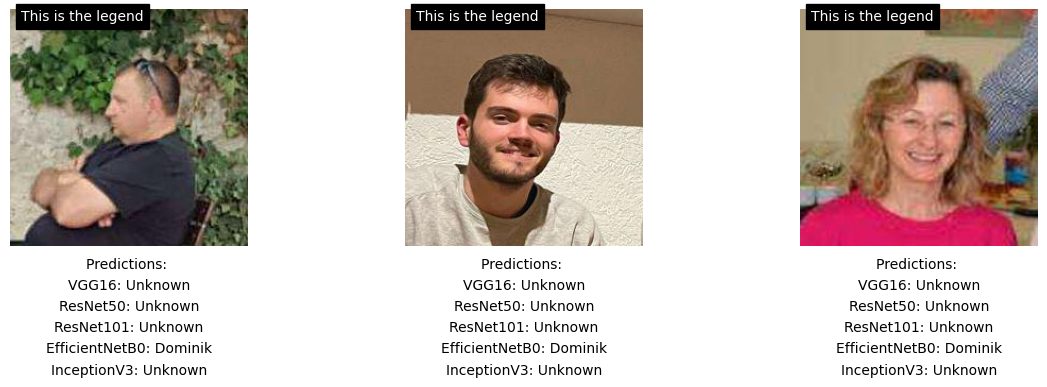

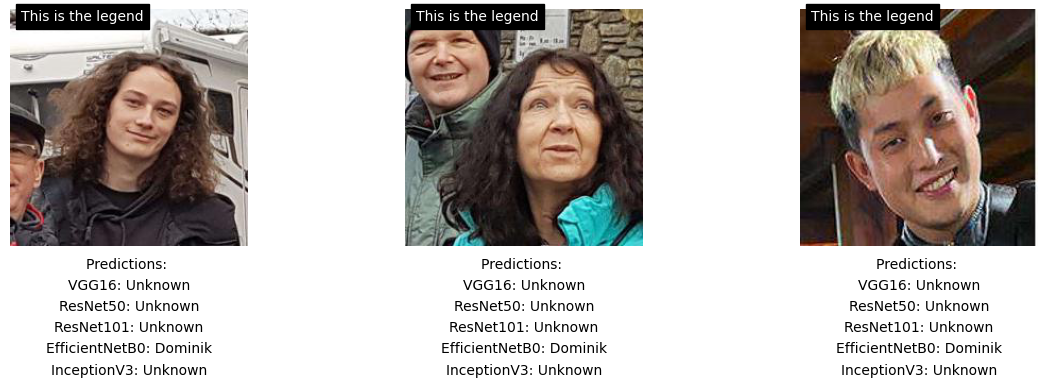

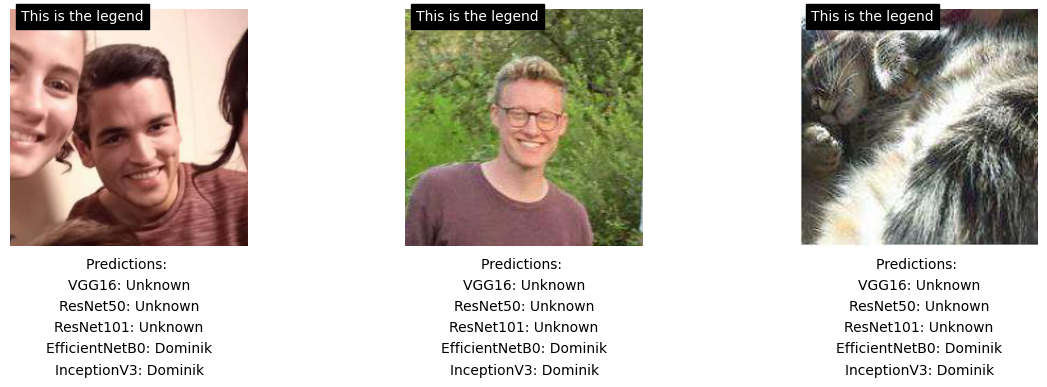

In [40]:
images_unknown = []
for i in range(len(test_images_unknown)):
    image = array_to_img(test_images_unknown[i])
    images_unknown.append(image)


for i in range(0, 12,3):
    # Create a figure and axes
    fig, ax = plt.subplots(1,3, figsize=(12, 4))

    # Display the image
    ax[0].imshow(images_unknown[i])
    ax[1].imshow(images_unknown[i+1])
    ax[2].imshow(images_unknown[i+2])

    # Add a legend
    legend_text = "This is the legend"
    ax[0].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[1].text(10, 10, legend_text, color='white', backgroundcolor='black')
    ax[2].text(10, 10, legend_text, color='white', backgroundcolor='black')

    # predictions
    text_vgg16 = "VGG16: " + labels_unknown_VGG16_model[i]
    text_ResNet50 = "ResNet50: " + labels_unknown_ResNet50_model[i]
    text_ResNet101 = "ResNet101: " + labels_unknown_ResNet101_model[i]
    text_EfficientNetB0 = "EfficientNetB0: " + labels_unknown_EfficientNetB0_model[i]
    text_InceptionV3 = "InceptionV3: " + labels_unknown_InceptionV3_model[i]

    # Add text under the image
    text_lines = ["Predictions: ", text_vgg16, text_ResNet50, text_ResNet101, text_EfficientNetB0, text_InceptionV3]
    text_position = (image.width // 2, image.height + 20)
    for line in text_lines:
        ax[0].text(*text_position, line, color='black', ha='center')
        ax[1].text(*text_position, line, color='black', ha='center')
        ax[2].text(*text_position, line, color='black', ha='center')
        text_position = (text_position[0], text_position[1] + 20)
        
    
    # Remove the axis labels
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    
    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

## 10. Live face recognition <a id="live"></a>

In [9]:
# Paths to the face recognition model and cascade files

# Load the .h5 models
model_path_VGG16 = 'models/VGG16_model.h5'
model_path_ResNet50 = 'ResNet50_model.h5'
model_path_ResNet101 = 'models/ResNet101_model.h5'
model_path_EfficientNetB0 = 'models/EfficientNetB0_model.h5'
model_path_InceptionV3 = 'models/InceptionV3_model.h5'


# Select one of the five pre-trained models, while keeping the remaining models commented out!
##############################################################################################
# model = load_model(model_path_VGG16)
model = load_model(model_path_ResNet50)
# model = load_model(model_path_ResNet101)
# model = load_model(model_path_EfficientNetB0)
# model = load_model(model_path_InceptionV3)
##############################################################################################

# Paths to the cascade file
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
# Create cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(face_cascade_path)

classes = { 0:'Dominik',  
            1:'Unknown'}

# Function to detect faces
def detect_faces(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(rgb, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))
    return faces

# Initialize webcam
cap = cv2.VideoCapture(0)


# Check if the webcam is available
if not cap.isOpened():
    print("No webcam found or access denied.")
else:
    # Infinite loop for face recognition
    while True:
        # Capture frame from the webcam
        ret, frame = cap.read()

        # Detect faces
        faces = detect_faces(frame)

        # Make predictions for each detected face
        for (x, y, w, h) in faces:
            
            # Expand the frame of the face
            margin = 40
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1], x + w + margin) - x
            h = min(frame.shape[0], y + h + margin) - y

            
            face_image = frame[y:y+h, x:x+w]
            
            #face_image = np.expand_dims(face_image, axis=0)
            face_image = img_to_array(face_image)
            face_image = cv2.normalize(face_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            face_image = array_to_img(face_image)
            face_image = face_image.resize((224, 224))
            face_image = np.expand_dims(face_image, axis=0)
            face_image = np.array(face_image)

            # Perform face classification
            predictions = np.argmax(model.predict(face_image), axis=1)[0]        
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, classes[predictions], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the frame
        cv2.imshow('Face Recognition', frame)

        # Exit the loop by pressing 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the webcam stream
cap.release()
cv2.destroyAllWindows()


## 11. Discussion of the results <a id="Conclusion"></a>

Kurze Zusammenfassung wie gut die Modelle sind und wie gut der Live Modus funktioniert